# Learning objectives

In this Exercise, we will see : 

- An end to end segmentation workflow for multi modality images

Adapted from : https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

# Installing dependencies

The following cell tries to import MONAI and will install its dependencies if needed in the NoteBook environment.

In [1]:
#@formatter:off
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.2.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
#@formatter:on

# Verify your Configuration

Execute the following cell to check MONAI's configuration using MONAI's `print_config()`.

In [2]:
from monai.config import print_config

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.1
Pytorch version: 2.1.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: C:\Work\Projects\2023_10_19_Formation_Medical_AI_EPITA\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
Pillow version: 10.1.0
Tensorboard version: 2.14.1
gdown version: 4.7.1
TorchVision version: 0.16.0+cpu
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.6
pandas version: 2.1.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.7.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies


# Setting the BRATS directory

In this exercise, we will be using the BRATS 2016 and 2017 datasets from the Medical Decathlon dataset.

In [3]:
from monai.utils import set_determinism
from monai.apps import DecathlonDataset
from pathlib import Path

set_determinism(seed=0)
directory = "./Data/brats"
Path(directory).mkdir(exist_ok=True)

# Download the dataset using the DecathlonDataset class
task_name = "Task01_BrainTumour"
if not Path(directory).joinpath(task_name).exists():
    ds = DecathlonDataset(
        root_dir=directory,
        task=task_name,
        section="training",
        download=True,
        cache_rate=0.0,
    )

# Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [4]:
from monai.transforms import MapTransform
import torch


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

# Setup transforms for training and validation

1. (option) Reduce the RandSpatialCropd ROI Size (depends on GPU)
2. From the train transform, create a validation transform pipelines


In [5]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd, RandSpatialCropd, RandFlipd,
    NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd
)

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[112, 112, 72], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_transform = Compose([fixMe])

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


# Data loading

1. List the training files and validation files in the brats folder
2. Create a dictionary for the files
3. Create two Persistent datasets for the train and validation files with their associated transforms

In [20]:
from monai.data import PersistentDataset, DataLoader
from sklearn.model_selection import train_test_split

cache_dir = Path("./Outputs/brats_cache")

images = fixMe
labels = fixMe

train_images, val_images, train_labels, val_labels = train_test_split(fixMe)
train_data_dict = fixMe
val_data_dict = fixMe
print(f"Train data size : {len(train_data_dict)}")
print(f"Val data size : {len(val_data_dict)}")

train_ds = fixMe
val_ds = fixMe

# Change these values to limit the training / validation size
max_train_size = 10  # len(train_ds)
max_val_size = 10  # len(val_ds)
train_loader = DataLoader(train_ds[:max_train_size], batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds[:max_val_size], batch_size=1, shuffle=False)

Train data size : 290
Val data size : 194


# Check data shape and visualize

1. Take the first validation data
2. Print the dimension of the data
3. Display the validation image using matshow3d
4. Display the validation label using matshow3d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 240, 240, 155])


invalid value encountered in cast


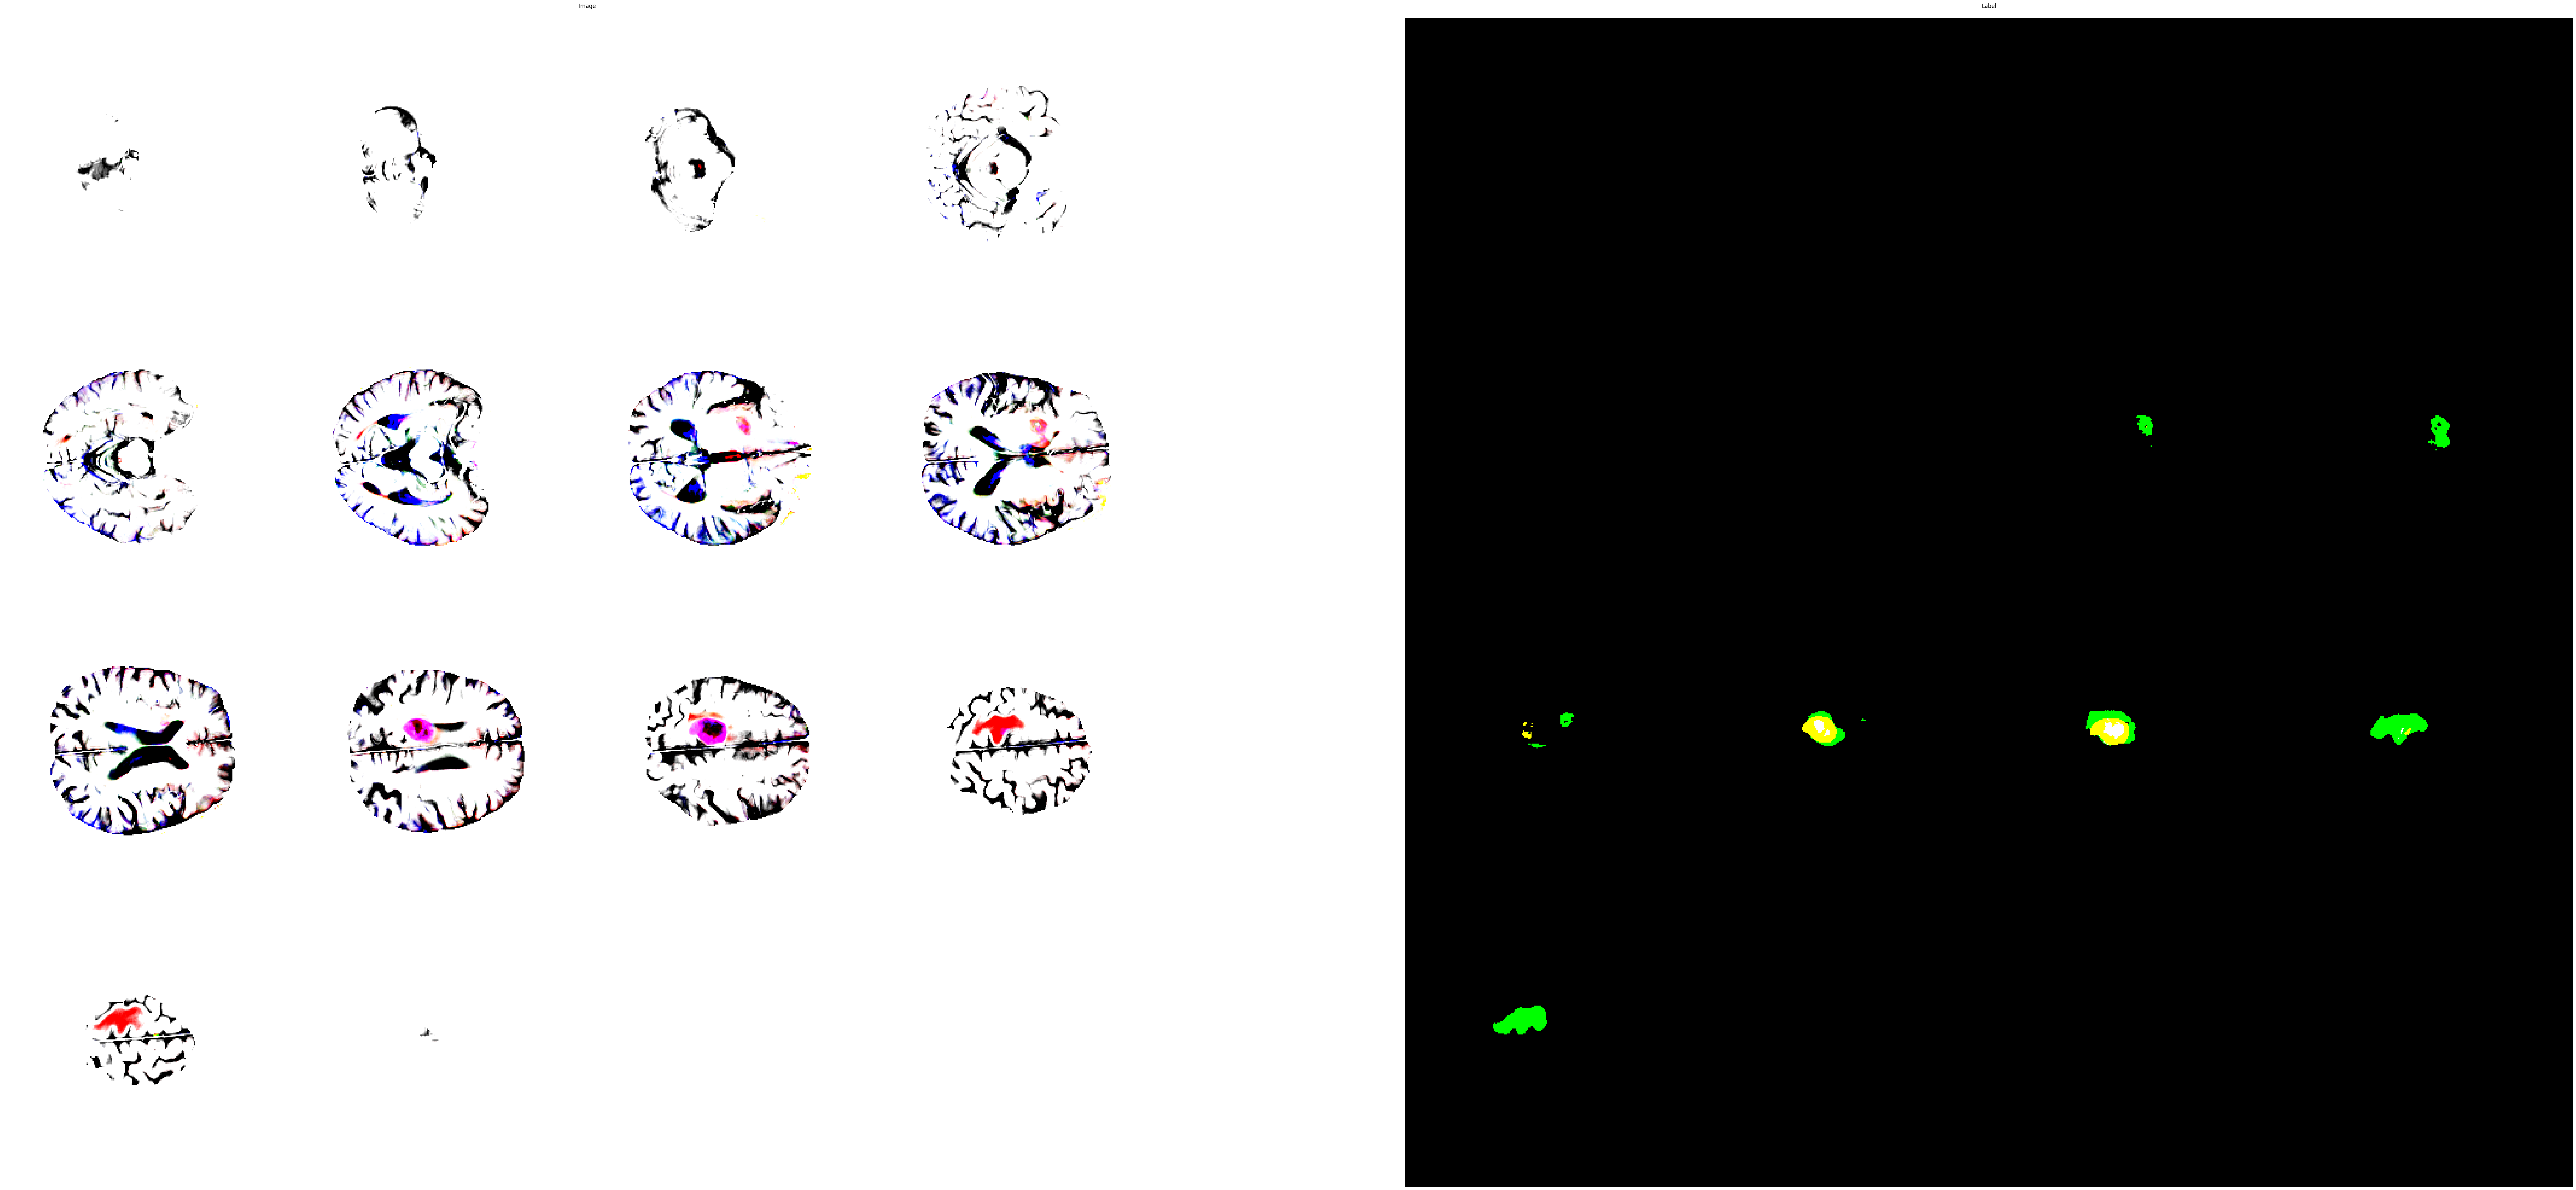

In [7]:
from matplotlib import pyplot as plt
from monai.visualize import matshow3d

val_data_example = fixMe
print(val_data_example["image"].shape)

fig = plt.figure(figsize=(100, 100))
plt.subplot(1, 2, 1)
_ = matshow3d(fixMe)
plt.subplot(1, 2, 2)
_ = matshow3d(fixMe)


# Create Model, Loss, Optimizer

In [21]:
from monai.networks.nets import SegResNet
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.losses import DiceLoss

max_epochs = 10 # 300
val_interval = 1

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Execute a typical PyTorch training process

1. (Train) From the input batch 
    - Initialize the optimizer gradients
    - Compute the outputs
    - Backpropagate the loss
    - Step the optimizer
2. (Validation) 
    1. Add a sliding_window_inference to evaluate the model over the validation data
    2. Save the best model to `.\Data\brats\best_metric_model.pth`

In [23]:
import time
import os
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        fixMe # init optimizer
        outputs = fixMe # compute  outputs
        loss = fixMe # compute loss
        fixMe # backprop loss
        fixMe # step optimizer
        epoch_loss += loss.item()
        print(
            f"{step}/{max_train_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = fixMe
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                fixMe
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/100
1/290, train_loss: 0.5380, step time: 0.4576
2/290, train_loss: 0.6833, step time: 0.1530
3/290, train_loss: 0.9376, step time: 0.1480
4/290, train_loss: 0.7181, step time: 0.1470
5/290, train_loss: 0.6993, step time: 0.1482
6/290, train_loss: 0.9021, step time: 0.1450
7/290, train_loss: 0.9988, step time: 0.1470
8/290, train_loss: 0.9175, step time: 0.1455
9/290, train_loss: 0.8431, step time: 0.1474
10/290, train_loss: 1.0000, step time: 0.1420
11/290, train_loss: 0.8957, step time: 0.1470
12/290, train_loss: 1.0000, step time: 0.1464
13/290, train_loss: 0.9700, step time: 0.1460
14/290, train_loss: 0.9842, step time: 0.1459
15/290, train_loss: 0.9350, step time: 0.1459
16/290, train_loss: 0.8605, step time: 0.1460
17/290, train_loss: 1.0000, step time: 0.1470
18/290, train_loss: 0.8962, step time: 0.1440
19/290, train_loss: 0.6394, step time: 0.1440
20/290, train_loss: 0.9817, step time: 0.1460
21/290, train_loss: 0.8915, step time: 0.1440
22/290, train_loss: 

NotADirectoryError: [WinError 267] Nom de répertoire non valide: 'C:\\Users\\Thibault\\AppData\\Local\\Temp\\tmpdt4n3zlb\\a0fe0aa59cb53c295a2a3059009c874e.pt'

In [10]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.2128 at epoch: 4, total time: 167.57397770881653.


# Plot the loss and metric

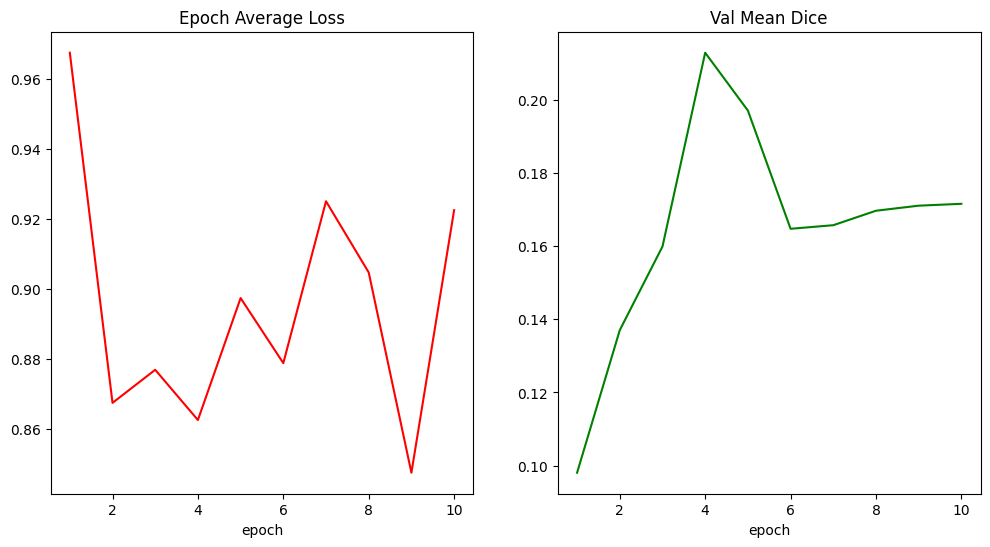

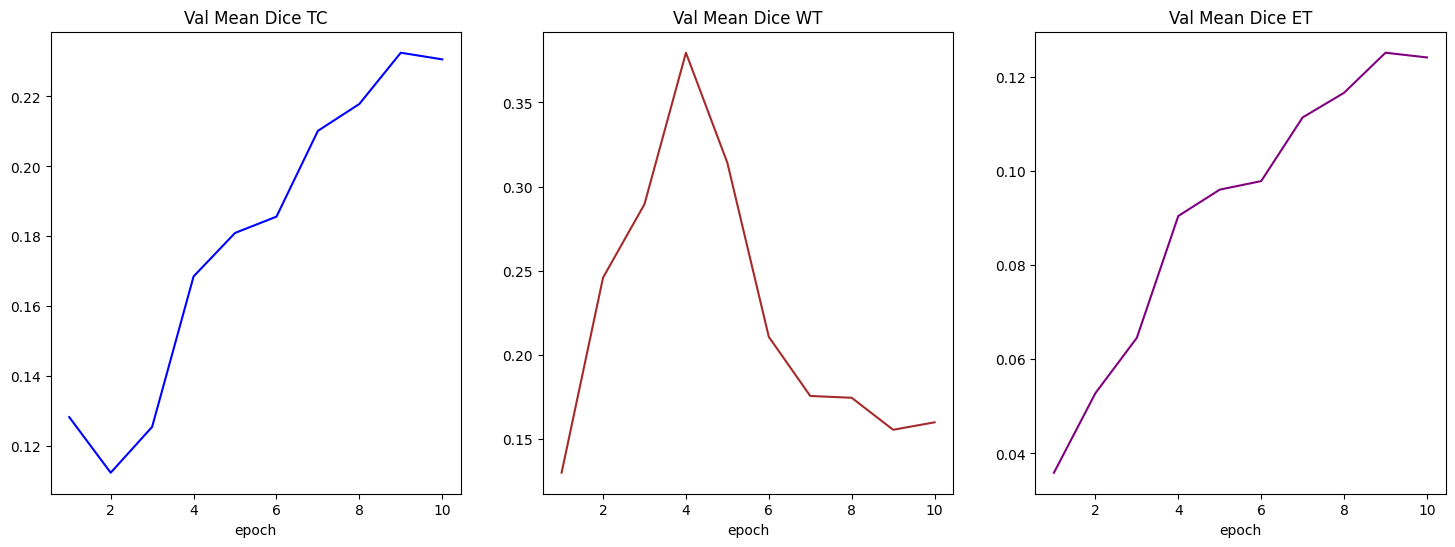

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

# Check best model output with the input image and label

1. Load the model state from the saved `.\Data\brats\best_metric_model.pth` path
2. Use the same `sliding_window_inference` to process the data
3. Display the results between ground truth and current

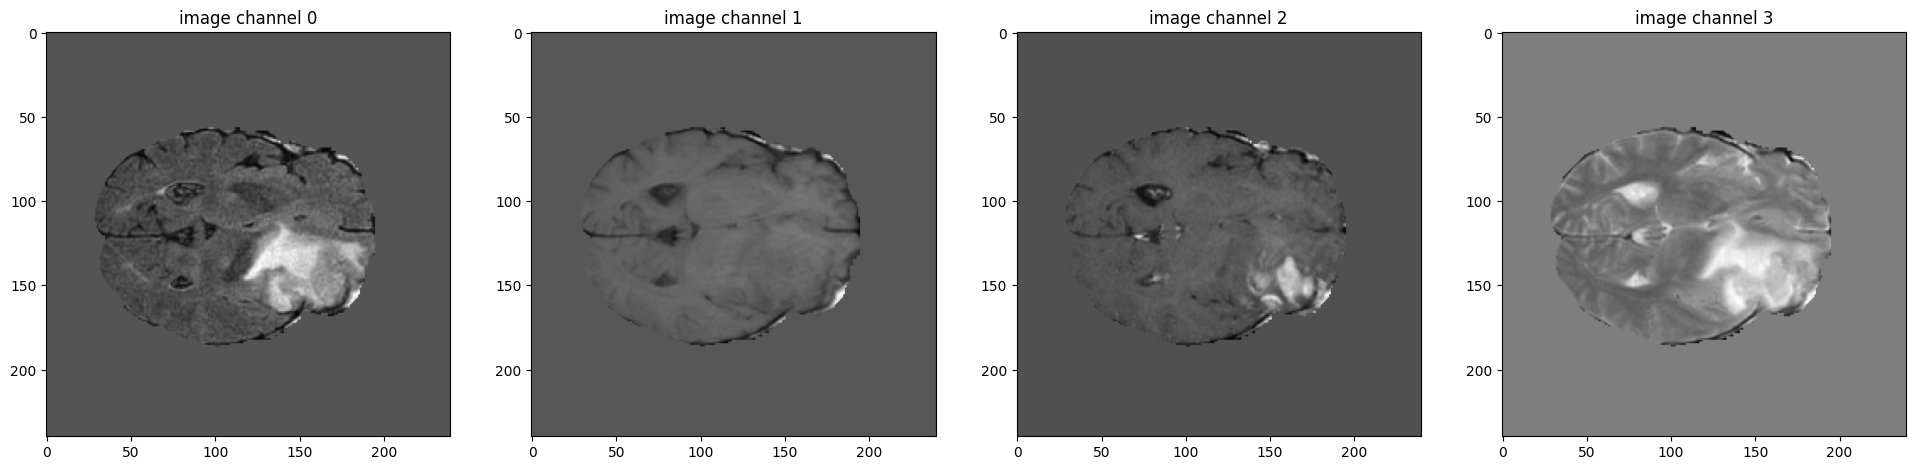

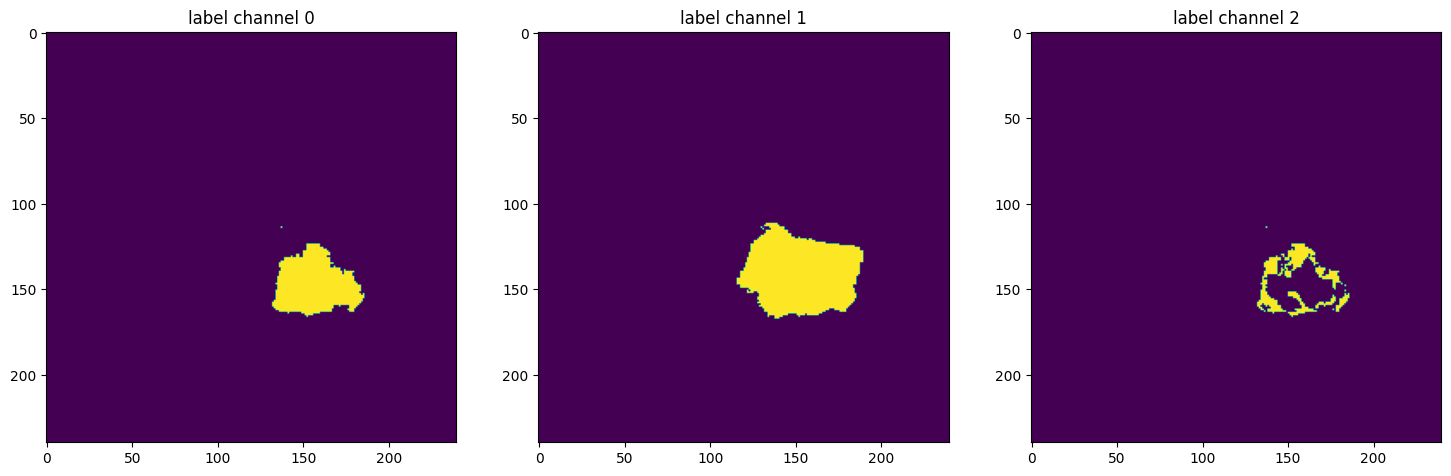

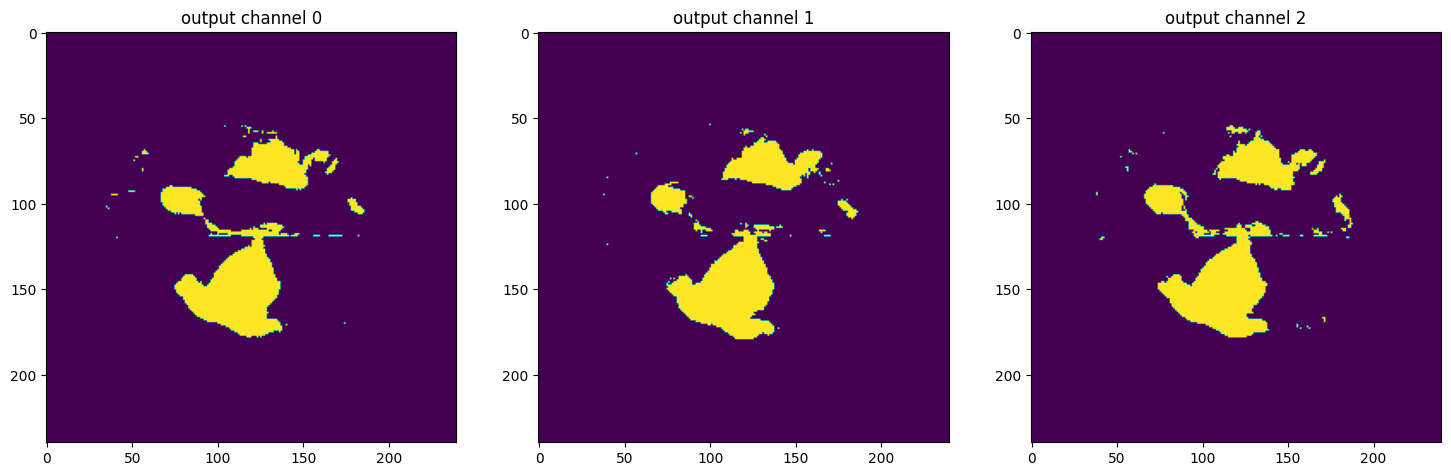

In [12]:
fixMe # load model state
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = fixMe
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

# Changing the model type

1. Modify the pipeline to use a UNet with ROI size (96,96,96) instead of the SegResNet model with 
    - Channels : (16, 32, 64, 128, 256)
    - Batch normalization
2. Adapt the train transform, train dataset and train loader for the new model (beware of persistent cache)
3. Adapt the validation sliding window to the new model
4. Run the sub sampled training loop and check the results.

In [13]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

train_transform_unet = Compose([fixMe])

cache_dir_unet = Path("./Outputs/brats_cache_UNet")
train_ds_unet = fixMe
train_loader_unet = DataLoader(train_ds_unet[:max_train_size], batch_size=1, shuffle=True)


model_unet = fixMe

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model_unet.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader_unet:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model_unet(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{max_train_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model_unet.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = fixMe
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model_unet.state_dict(),
                    os.path.join(directory, "best_metric_model_UNet.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


----------
epoch 1/10
1/10, train_loss: 1.0000, step time: 0.1966
2/10, train_loss: 0.9564, step time: 0.1041
3/10, train_loss: 0.8105, step time: 0.0938
4/10, train_loss: 0.9438, step time: 0.1957
5/10, train_loss: 0.8740, step time: 0.0463
6/10, train_loss: 0.9998, step time: 0.1350
7/10, train_loss: 0.9154, step time: 0.0626
8/10, train_loss: 0.9890, step time: 0.1723
9/10, train_loss: 0.8310, step time: 0.1406
10/10, train_loss: 1.0000, step time: 0.1406
epoch 1 average loss: 0.9320
saved new best metric model
current epoch: 1 current mean dice: 0.0119 tc: 0.0075 wt: 0.0205 et: 0.0077
best mean dice: 0.0119 at epoch: 1
time consuming of epoch 1 is: 21.4485
----------
epoch 2/10
1/10, train_loss: 0.9998, step time: 0.0471
2/10, train_loss: 1.0000, step time: 0.0469
3/10, train_loss: 0.9282, step time: 0.0373
4/10, train_loss: 1.0000, step time: 0.0469
5/10, train_loss: 1.0000, step time: 0.0418
6/10, train_loss: 0.9979, step time: 0.0312
7/10, train_loss: 0.9312, step time: 0.0312
8

# Plotting the losses

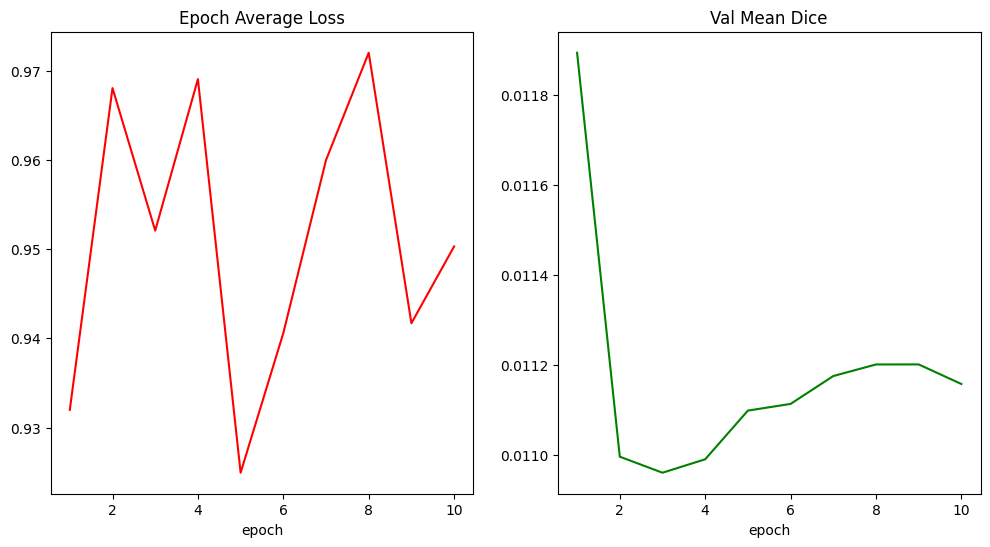

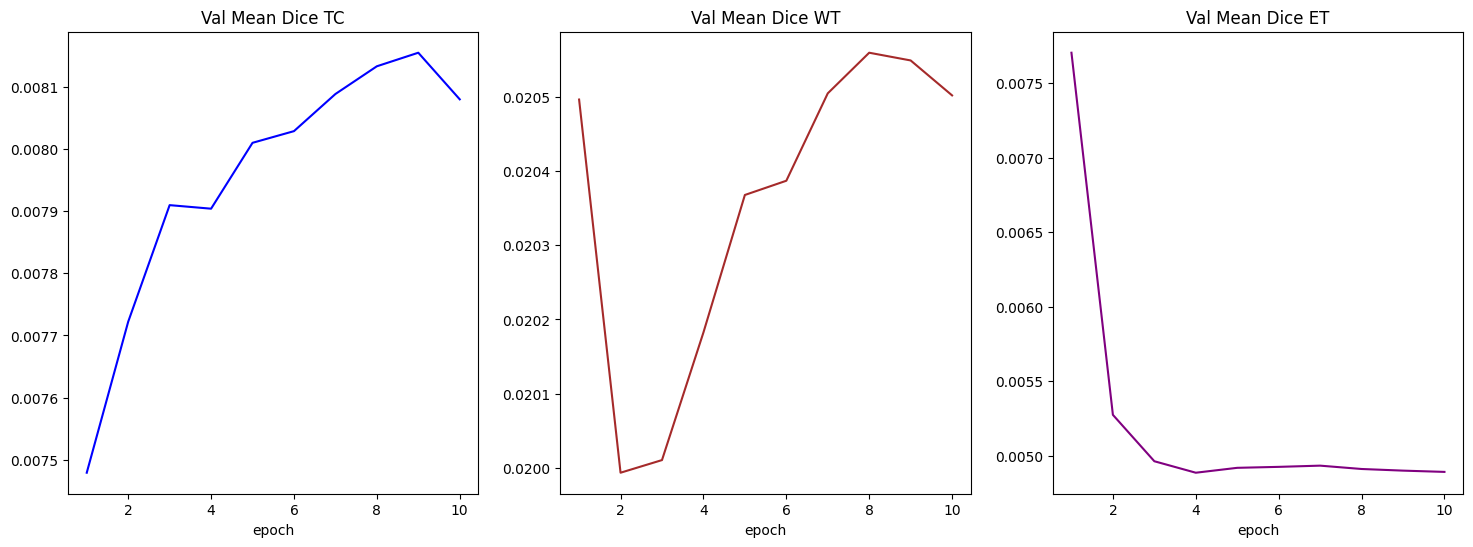

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

# Simplifying the training loop

1. Replace the training loop with a SupervisedTrainer
    - Create a validation post transform using MapTransforms with 
        - `EnsureTyped` for pred output
        - `Activationsd` with sigmoid
        - `AsDiscreted` conversion
2. Instantiate a `SupervisedEvaluator` with : 
    - The validation DataLoader  
    - a `SlidingWindowInferer` with the previous ROI configuration
    - a `MeanDice` validation metric using `from_engine` pred and label
3. Instantiate a `SupervisedTrainer` with : 
    - a `SimpleInferer` 
    - the previous supervised evaluator
4. Run the trainer, print the losses and see the results for the best model

see: https://github.com/Project-MONAI/tutorials/blob/main/modules/engines/unet_training_dict.py

In [15]:
from monai.engines import SupervisedTrainer, SupervisedEvaluator
from monai.inferers import SlidingWindowInferer, SimpleInferer
from monai.handlers import ValidationHandler, MetricLogger, MeanDice, from_engine, LrScheduleHandler, CheckpointSaver
from monai.transforms import Activationsd, AsDiscreted

val_handlers = [
    CheckpointSaver(save_dir="./Data/brats/checkpoint", save_dict={"net": model}, save_key_metric=True),
]

val_post_transforms = Compose([fixMe])

evaluator = fixMe

logger = MetricLogger(evaluator=evaluator)
train_handlers = [
    logger,
    LrScheduleHandler(lr_scheduler=lr_scheduler, print_lr=True),
    ValidationHandler(validator=evaluator, interval=2, epoch_level=True)
]

trainer = fixMe
trainer.run()

print("Training done")

for it, dice in logger.metrics["val_mean_dice"]:
    print(f"Val mean dice : {it} : {dice}")

Training done
Val mean dice : 20 : 0.18215741217136383
Val mean dice : 40 : 0.2790336012840271
Val mean dice : 60 : 0.23835515975952148
Val mean dice : 80 : 0.21002893149852753
Val mean dice : 100 : 0.21857698261737823


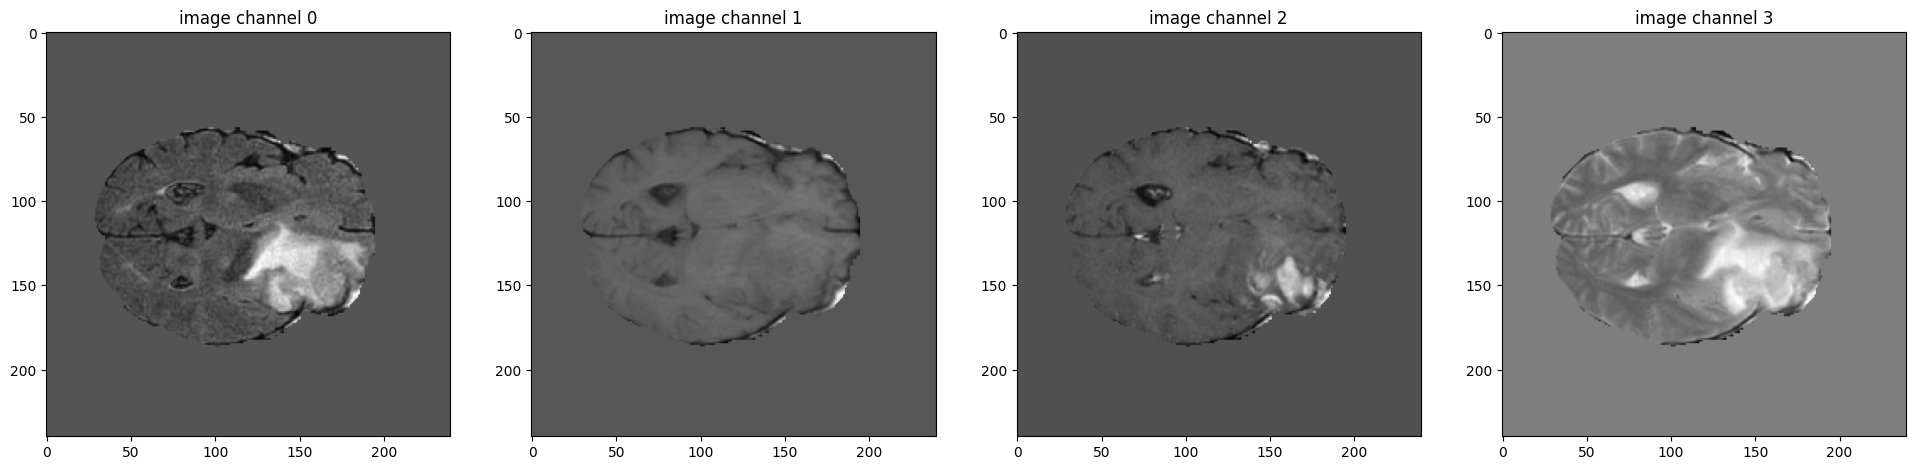

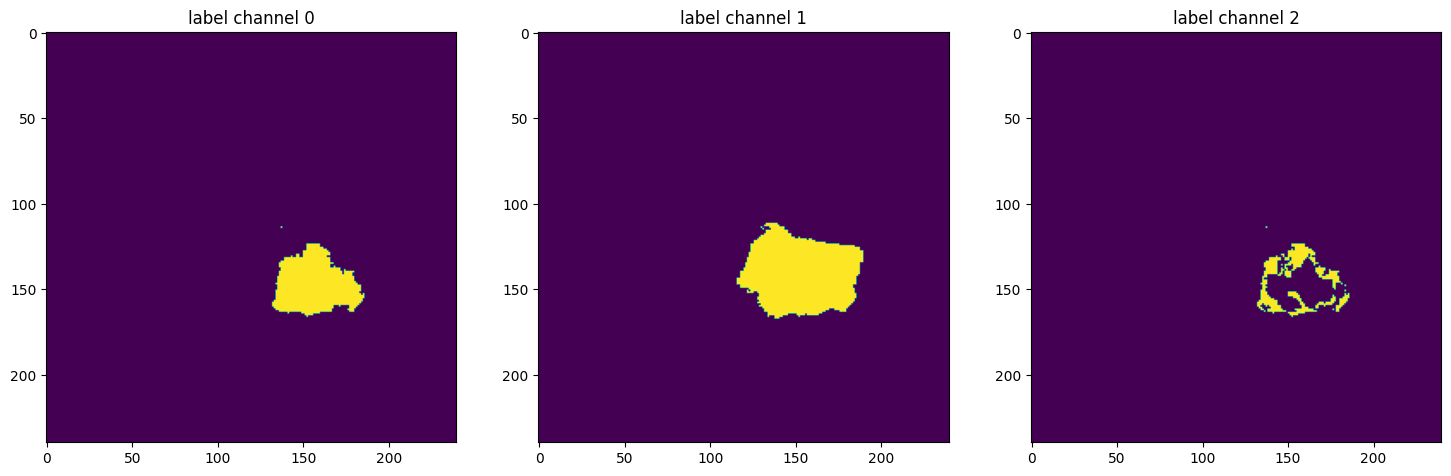

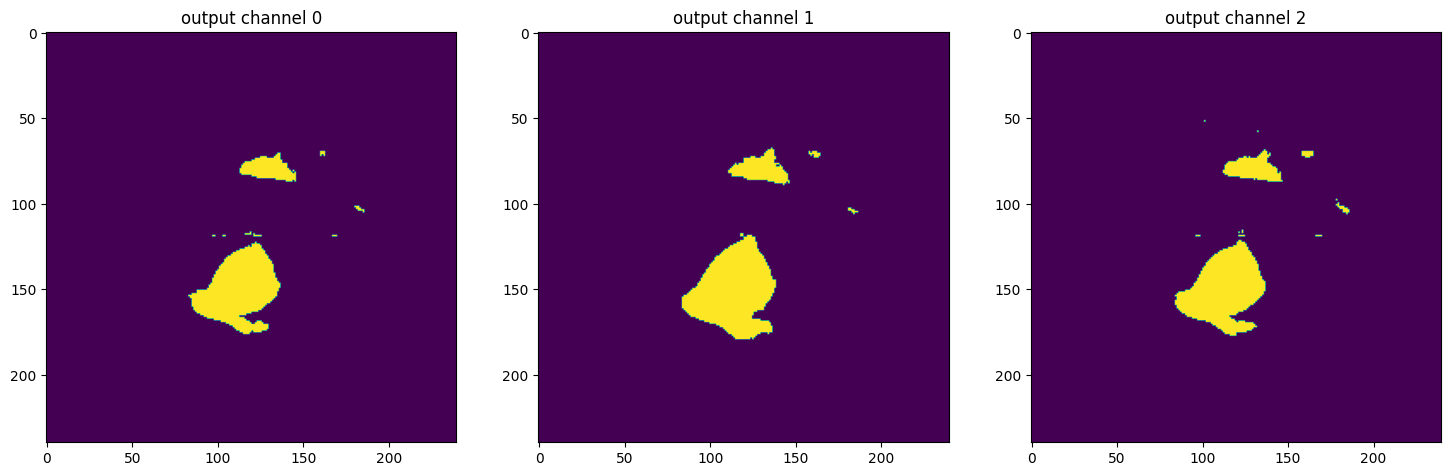

In [16]:
from pathlib import Path
best_metric = list(sorted(Path("./Data/brats/checkpoint").glob("*.pt")))[-1]

model.load_state_dict(torch.load(best_metric))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = sliding_window_inference(
        inputs=val_inputs,
        roi_size=(120, 120, 80),
        sw_batch_size=1,
        predictor=model,
        overlap=0.5,
    )
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

# Inference pipeline

1. Add an inference post transform to invert the results and save the output images
2. Create a SupervisedEvaluator with the inference post transform
3. Load and run the best model with the supervised evaluator

In [19]:
from monai.transforms import Invertd, SaveImaged

model.load_state_dict(torch.load(os.path.join(directory, "best_metric_model.pth")))
infer_post_transform = Compose([fixMe])

evaluator = fixMe

evaluator.run()

2023-11-02 08:47:46,565 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_389_infer.nii.gz
2023-11-02 08:47:48,295 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_416_infer.nii.gz
2023-11-02 08:47:50,016 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_006_infer.nii.gz
2023-11-02 08:47:51,730 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_371_infer.nii.gz
2023-11-02 08:47:53,509 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_402_infer.nii.gz
2023-11-02 08:47:55,256 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_012_infer.nii.gz
2023-11-02 08:47:57,032 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_182_infer.nii.gz
2023-11-02 08:47:58,813 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_292_infer.nii.gz
2023-11-02 08:48:01,085 INFO image_writer.py:197 - writing: Outputs\brats_infer\BRATS_035_infer.nii.gz
2023-11-02 08:48:03,129 INFO image_writer.py:197 - writing: Outputs\brats